In [2]:
%matplotlib inline
import io
import pickle


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils.extmath import log_logistic
from scipy.optimize import minimize


def process(data_string):
    try:
        return np.array(
            data_string.replace('\n', '').strip().split(' '), 
            dtype=np.longdouble
        )
    except ValueError:
        return ''

def get_data(verbose=False):
    with io.FileIO('ex3data1.dat') as file:
        # Throw out the header lines:
        for _ in range(5):
            line = file.readline()
            if verbose:
                print line
        data = [process(line) for line in file]
        # Throw out the footer lines:
        disguard1 = data.pop()
        disguard2 = data.pop()
        return np.array(data), disguard1, disguard2


def pickle_data(data):
    with open('ex3data1_py.dat', 'w') as file:
        s = pickle.dumps(data)
        file.write(s)
        
data128, d1, d2 = get_data()
assert not d1
assert not d2
assert data128.shape == (5000, 400)
        
def transpose():
    """ Likely because Octave is column-major and numpy is row-major, each image when loaded is transposed. """
    m, n = data128.shape
    assert n == 400
    for index, row in enumerate(data128):
        transposed = row.reshape(20, 20).T.reshape(1, n)
        data128[index, :] = transposed
transpose()
    
print 'done'

done


In [3]:
def get_labels():
    with io.FileIO('y.dat') as file:
        return np.array([np.int(float(line)) for line in file.readlines()])
        
y0 = get_labels()
y = y0.copy()    
# Octave uses 1-indexing, so to prevent confusion, MNIST '0's were labelled as '10'. 
y[y == 10] = 0

# Logistic regression cost functions:

In [135]:
def cost_1(z):
    idx = z > 0
    out = np.zeros(z.shape)
    out[idx] = np.log1p(np.exp(-z[idx]))
    out[~idx] = -z[~idx] + np.log1p(np.exp(z[~idx]))
    return out


def cost_0(z):
    idx = z < 0
    out = np.zeros(z.shape)
    out[idx] = np.log1p(np.exp(z[idx]))
    out[~idx] = z[~idx] + np.log1p(np.exp(-z[~idx]))
    return out



def cost(theta, X, y, lambd, debug, **kwargs):
    """ Logistic regression cost function with optional regularization. `Lambd` is the regularization constant. """
    m = X.shape[0]
    # j = y.dot(log_logistic(X.dot(theta)))  + (1 - y).dot(1 - )
    XT = X.dot(theta)
    cost1 = cost_1(XT)
    cost0 = cost_0(XT)
    j = y.dot(cost1)  + (1 - y).dot(cost0)
    if debug:
        print 'X Theta = {}'.format(XT)
        print 'cost0 = {}'.format(cost0)
        print 'cost1 = {}'.format(cost1)
        print 'unreg cost: {}'.format(j)

    regularization = (float(lambd)/float(2*m)) * theta[1:].dot(theta[1:].T)
    j /= m
    j += regularization
    return j


def sigmoid(z):
    idx = z > 0
    out = np.zeros(z.shape)
    out[idx] = 1/(1 + np.exp(-z[idx]))
    out[~idx] = np.exp(z[~idx])/(np.exp(z[~idx]) + 1)
    return out

def grad(theta, X, y, lambd, debug, **kwargs):
    m = X.shape[0]
    regularization_theta = theta.copy()
    regularization_theta[0] = 0
    return ((sigmoid(X.dot(theta)) - y).dot(X))/m + (float(lambd)/m)*regularization_theta.astype(float)

In [5]:
def get_data_class(data_class):
    """ Returns one of the number classes from the dataset"""
    X_0 = X.copy()
    X_0 = X[y==data_class, :]
    return X_0


In [6]:
def check_functions(grad_func, cost_func):
    '''
    Asserts that the cost and gradient functions return known corret values for a given theta, X, y.  
    Test case from https://www.coursera.org/learn/machine-learning/discussions/weeks/3/threads/tA3ESpq0EeW70BJZtLVfGQ
    The expected cost is 4.6832.
    The expected gradient = [0.31722, 0.87232, 1.64812, 2.23787]
    '''
    test_X = np.array([[1, 8, 1, 6], [1, 3, 5, 7], [1, 4, 9, 2]])  # X
    test_y = np.array([[1, 0, 1]])  # y
    test_theta = np.array([-2, -1, 1, 2])
    
    grad_diff = grad(test_theta, test_X, test_y, 0, False) - np.array([0.31722, 0.87232, 1.64812, 2.23787])
    assert grad_diff.dot(grad_diff.T) < 0.0001
    calculated_cost = cost(test_theta, test_X, test_y, 0, False)
    assert abs(calculated_cost - 4.6832) < 0.0001, calculated_cost
    
check_functions(grad, cost)


In [147]:
k = len(set(y))  # num of classes, in this case the digits '0' thru '9'
m, features = data128.shape
X0 = data128.copy()
Theta = np.zeros((k, features + 1))
initial_theta = np.zeros(features+1)
X = np.concatenate([np.ones((X0.shape[0], 1)), X0], axis=1)

def scale_features(X_input):
    """ Subtract the mean of each feature from that column of features, then divide by the Std. """
    X = X_input.copy()
    features = X.shape[1]
    for column in range(features):
        X[:, column] -= X[:, column].mean()
        if X[:, column].std() != 0:
            X[:, column] /= X[:, column].std()
    return X

def normalize_rows(X_input):
    """ Subtract the max of each row from that row. """
    print 'starting row normalization...'
    X = X_input.copy()
    for row in X_input:
        row -= row.max()
    print 'finished row normalization.'
    return X


def minimize_class(X_i, y_i, maxiter=None):
    options = {'disp': True}
    if maxiter:
        options['maxiter'] = maxiter
    return minimize(
        fun=cost, 
        x0=initial_theta, 
        method='CG',
        args=(X_i, y_i, 0.1, debug), 
        jac=grad,
        options=options
    )
    
debug = False

def train(X, y, scale=False, normalize=True, maxiter=None):    
    
    if scale:
        X = scale_features(X)
    if normalize:
        X = normalize_rows(X)
        
    for klass in range(len(set(y))):
        print 'starting with %s' % klass
        result = minimize_class(X, (y==klass).astype(np.int), maxiter=maxiter)

        if result.success:
            Theta[klass, :] = result.x
        else:
            print "Failed for %s" % klass
            Theta[klass, :] = result.x

train(X, y, scale=False, normalize=False, maxiter=None)
print 'done!'


starting with 0
Optimization terminated successfully.
         Current function value: 0.008581
         Iterations: 154
         Function evaluations: 942
         Gradient evaluations: 942
starting with 1
Optimization terminated successfully.
         Current function value: 0.013137
         Iterations: 186
         Function evaluations: 1147
         Gradient evaluations: 1147
starting with 2
Optimization terminated successfully.
         Current function value: 0.050808
         Iterations: 279
         Function evaluations: 1081
         Gradient evaluations: 1081
starting with 3
Optimization terminated successfully.
         Current function value: 0.057606
         Iterations: 399
         Function evaluations: 1522
         Gradient evaluations: 1522
starting with 4
Optimization terminated successfully.
         Current function value: 0.033078
         Iterations: 249
         Function evaluations: 1104
         Gradient evaluations: 1104
starting with 5
Optimization terminat

In [148]:
prediction_matrix = X.dot(Theta.T)
predictions = np.argmax(prediction_matrix, axis=1)
print float(sum(predictions == y))/X.shape[0]


0.9646


[ 4.7637111 -0.90613545  0.34388353  0.34377737 -1.5196539 -0.11752091
 -0.034346851 -0.88766116  0.47156288 -0.0050522078]
0


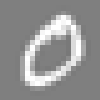

Predicted as: 8


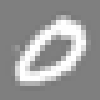

Predicted as: 8


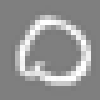

Predicted as: 1


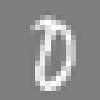

Predicted as: 1


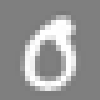

Predicted as: 1


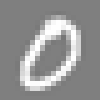

Predicted as: 1


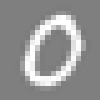

Predicted as: 8


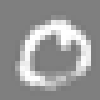

Predicted as: 1


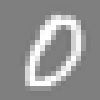

Predicted as: 1


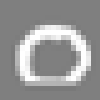

Predicted as: 1


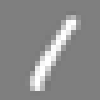

Predicted as: 8


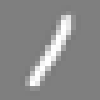

Predicted as: 3


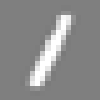

Predicted as: 2


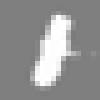

Predicted as: 2


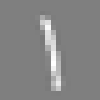

Predicted as: 2


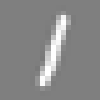

Predicted as: 2


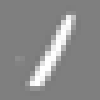

Predicted as: 2


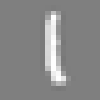

Predicted as: 6


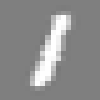

Predicted as: 2


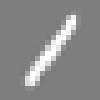

Predicted as: 2


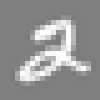

Predicted as: 0


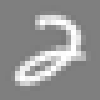

Predicted as: 3


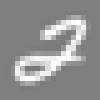

Predicted as: 3


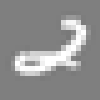

Predicted as: 3


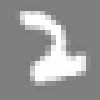

Predicted as: 3


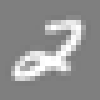

Predicted as: 3


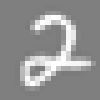

Predicted as: 3


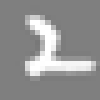

Predicted as: 3


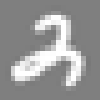

Predicted as: 3


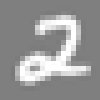

Predicted as: 3


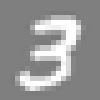

Predicted as: 4


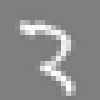

Predicted as: 4


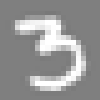

Predicted as: 4


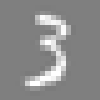

Predicted as: 6


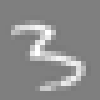

Predicted as: 4


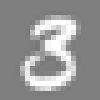

Predicted as: 4


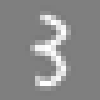

Predicted as: 4


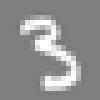

Predicted as: 4


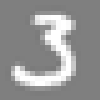

Predicted as: 4


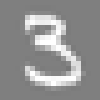

Predicted as: 4


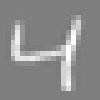

Predicted as: 6


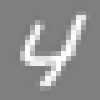

Predicted as: 6


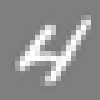

Predicted as: 6


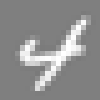

Predicted as: 6


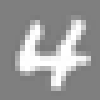

Predicted as: 6


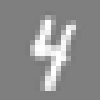

Predicted as: 5


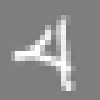

Predicted as: 5


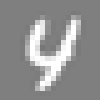

Predicted as: 5


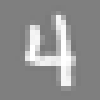

Predicted as: 6


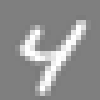

Predicted as: 6


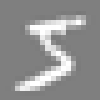

Predicted as: 6


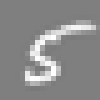

Predicted as: 6


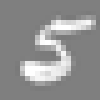

Predicted as: 6


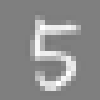

Predicted as: 6


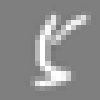

Predicted as: 6


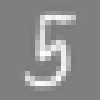

Predicted as: 6


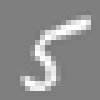

Predicted as: 6


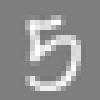

Predicted as: 6


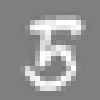

Predicted as: 6


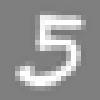

Predicted as: 6


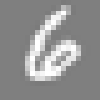

Predicted as: 7


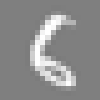

Predicted as: 7


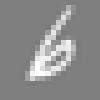

Predicted as: 7


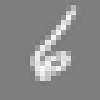

Predicted as: 9


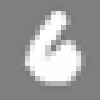

Predicted as: 7


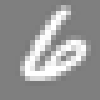

Predicted as: 9


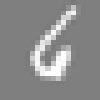

Predicted as: 7


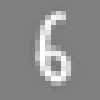

Predicted as: 3


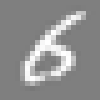

Predicted as: 7


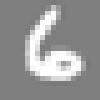

Predicted as: 7


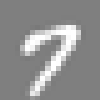

Predicted as: 8


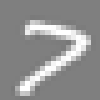

Predicted as: 3


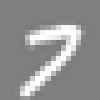

Predicted as: 8


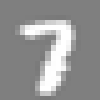

Predicted as: 8


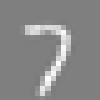

Predicted as: 8


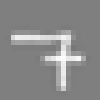

Predicted as: 8


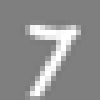

Predicted as: 3


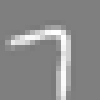

Predicted as: 8


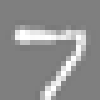

Predicted as: 8


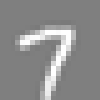

Predicted as: 8


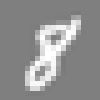

Predicted as: 9


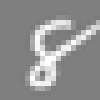

Predicted as: 0


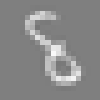

Predicted as: 9


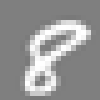

Predicted as: 9


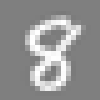

Predicted as: 9


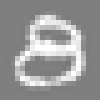

Predicted as: 6


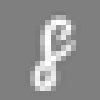

Predicted as: 9


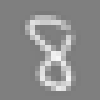

Predicted as: 2


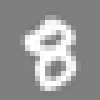

Predicted as: 9


In [96]:
a = prediction_matrix[22, :]
print a
print np.argmax(a)

wrong_predictions = predictions[predictions != y]

counter = 0
for prediction, actual in zip(predictions, y):
    if prediction == y[counter]:
        continue
    if counter % 50 == 0:
        img = row2image(X[counter, 1:])
        img.resize((100, 100))
        display(img)
        print 'Predicted as: {}'.format(prediction)
            
    counter += 1


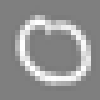

In [46]:
from PIL import Image
from numpy import interp
from IPython.display import display


# A feature scaled image: 
def row2image(row):
    img = interp(np.float64(row), [-1, 1], [0, 1])
    img *= 255
    image = Image.fromarray(img.reshape((20, 20))).convert('RGB')
    return image.resize((100, 100))

img = row2image(X[13, 1:])
img


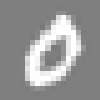

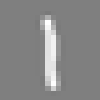

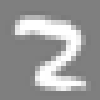

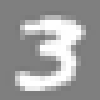

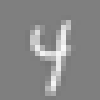

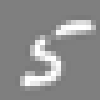

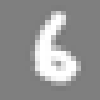

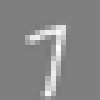

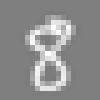

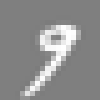

In [74]:
# The raw data:
    
for index in range(3, 5000, 500):
    row = data128[index, :]
    display(row2image(row))


# Test cases:

% input
theta = [-2; -1; 1; 2];

X = [ones(5,1) reshape(1:15,5,3)/10];

y = [1;0;1;0;1] >= 0.5;       % creates a logical array

lambda = 3;

[J grad] = lrCostFunction(theta, X, y, lambda)

% results
J =  2.5348

grad =

   0.14656
  -0.54856
   0.72472
   1.39800

In [144]:
test_theta = np.array([-2, -1, 1, 2], dtype=np.float)
test_X = np.arange(1, 16).reshape(3, 5).T/10.0
test_X = np.concatenate([np.ones((5, 1)), test_X], axis=1)
test_y = np.array([1, 0, 1, 0, 1]) >= 0.5
lambd = 3

print test_X
print test_theta
print cost(test_theta, test_X, test_y, lambd, True)
print grad(test_theta, test_X, test_y, lambd, True)

[[ 1.   0.1  0.6  1.1]
 [ 1.   0.2  0.7  1.2]
 [ 1.   0.3  0.8  1.3]
 [ 1.   0.4  0.9  1.4]
 [ 1.   0.5  1.   1.5]]
[-2. -1.  1.  2.]
X Theta = [ 0.7  0.9  1.1  1.3  1.5]
cost0 = [ 1.10318605  1.24115387  1.38733533  1.54100845  1.70141328]
cost1 = [ 0.40318605  0.34115387  0.28733533  0.24100845  0.20141328]
unreg cost: 3.67409698055
2.53481939611
[ 0.14656137 -0.54855841  0.72472227  1.39800296]


In [ ]:
print grad

In [146]:
test_X = np.array([
    [8.00000,   1.00000,   6.00000],
    [3.00000,   5.00000,   7.00000],
    [4.00000,   9.00000,   2.00000],
    [0.84147,   0.90930,   0.14112],
    [0.54030,  -0.41615,  -0.98999],
])
test_y = np.array([1, 2, 2, 1, 3])
num_labels = 3
lambd = 0.1

array([[ 8.     ,  1.     ,  6.     ],
       [ 3.     ,  5.     ,  7.     ],
       [ 4.     ,  9.     ,  2.     ],
       [ 0.84147,  0.9093 ,  0.14112],
       [ 0.5403 , -0.41615, -0.98999]])